<a href="https://colab.research.google.com/github/ayuugoyal/conveyeye/blob/main/Copy_of_OCR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 12.2 MB/s eta 0:00:00


Recognized Text:
816743
196854
& Control No
51488B0P3
Mfg Date
11 FEB 2024
Exp Date
11 FEB 2028
Lot


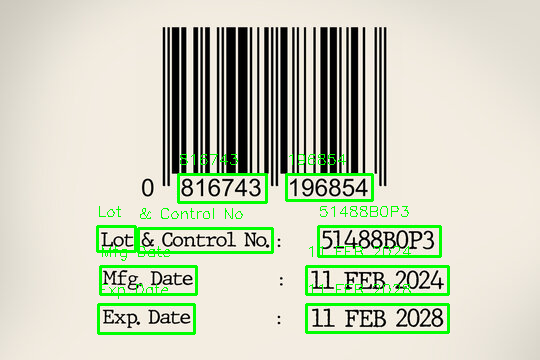

In [ ]:
import cv2
import easyocr
from google.colab.patches import cv2_imshow  # Import for displaying images in Colab

# Function to perform OCR on the image
def perform_ocr(image_path):
    # Initialize EasyOCR Reader
    reader = easyocr.Reader(['en'], gpu=False)

    # Load the image
    image = cv2.imread(image_path)

    # Perform OCR
    ocr_output = reader.readtext(image)

    return image, ocr_output

# Function to display recognized text
def display_recognized_text(ocr_output):
    recognized_text = []
    for _, text, _ in ocr_output:
        recognized_text.append(text)
    return recognized_text

# Function to draw bounding boxes and display text
def display_image_with_boxes(image, ocr_output):
    for (bbox, text, confidence) in ocr_output:
        # Draw bounding box
        cv2.rectangle(image, (int(bbox[0][0]), int(bbox[0][1])), (int(bbox[2][0]), int(bbox[2][1])), (0, 255, 0), 2)
        # Display text on image
        cv2.putText(image, text, (int(bbox[0][0]), int(bbox[0][1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Show the image with bounding boxes using cv2_imshow
    cv2_imshow(image)  # Use this function in Colab to display the image
    cv2.waitKey(0)

# Main function
def main(image_path):
    # Perform OCR
    image, ocr_output = perform_ocr(image_path)

    # Display recognized text
    recognized_text = display_recognized_text(ocr_output)
    print("Recognized Text:")
    for text in recognized_text:
        print(text)

    # Display the image with bounding boxes
    display_image_with_boxes(image, ocr_output)

# Example usage
if __name__ == "__main__":
    image_path = '/content/360_F_752643470_fvmjwcFcUIBLEbHuyiwR6tu97fOgMtAx.jpg'  # Update this with your image path
    main(image_path)



In [1]:
!pip install fastapi uvicorn easyocr opencv-python-headless numpy
from fastapi import FastAPI, File, UploadFile
import cv2


import easyocr
import cv2
import numpy as np
import re
from google.colab.patches import cv2_imshow  # For displaying images in Colab

app = FastAPI()


# Function to perform OCR
def perform_ocr(image_path):
    reader = easyocr.Reader(['en'])
    image = cv2.imread(image_path)
    ocr_output = reader.readtext(image)
    return image, ocr_output

# Function to display recognized text
def display_recognized_text(ocr_output):
    recognized_text = []
    for (bbox, text, prob) in ocr_output:
        recognized_text.append(text)
    return recognized_text

# Function to extract useful information
def extract_useful_information(recognized_text):
    manufacturing_date = None
    expiry_date = None
    company_name = None

    text_string = " ".join(recognized_text)

    # Updated regex patterns for MFG and Expiry Dates
    mfg_pattern = r'(Mfg Date|Manufactured On|Manufacture Date|Packed On|Pack Date|Made On|Date of Manufacture)\s*([0-9]{1,2}\s*[A-Z]{3}\s*[0-9]{4}|[0-9]{1,2}/[0-9]{1,2}/[0-9]{4}|[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,4})'
    exp_pattern = r'(Exp Date|Expiry Date|Expired On|Best Before|Best Before Use|Use By)\s*([0-9]{1,2}\s*[A-Z]{3}\s*[0-9]{4}|[0-9]{1,2}/[0-9]{1,2}/[0-9]{4}|[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,4}|([0-9]+)\s*Days|([0-9]+)\s*Year)'
    company_pattern = r'(Mktd by|Pkd by|Manufactured by|Marketing By)\s*([A-Za-z0-9\s&,.]+)'

    # Search for manufacturing date
    mfg_match = re.search(mfg_pattern, text_string, re.IGNORECASE)
    if mfg_match:
        manufacturing_date = mfg_match.group(2)

    # If manufacturing date is still None, try to find it more generally
    if not manufacturing_date:
        general_mfg_pattern = r'MFG Date\s*([0-9]{1,2}/[0-9]{1,2}/[0-9]{4})|([0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{2,4})'
        general_match = re.search(general_mfg_pattern, text_string)
        if general_match:
            manufacturing_date = general_match.group(1) or general_match.group(2)

    # Search for expiry date or "Best Before"
    exp_match = re.search(exp_pattern, text_string, re.IGNORECASE)
    if exp_match:
        expiry_date = exp_match.group(2) if exp_match.group(2) else exp_match.group(1)

    # If the expiry date mentions "Best Before" with a duration
    if 'Best Before' in text_string and 'Days' in text_string:
        days_before = re.search(r'Best Before\s*([0-9]+)\s*Days', text_string)
        if days_before:
            expiry_date = f"{days_before.group(1)} Days from MFG Date"

    # Search for company name
    company_match = re.search(company_pattern, text_string, re.IGNORECASE)
    if company_match:
        company_name = company_match.group(2).strip()

    return company_name, manufacturing_date, expiry_date

# Function to display image with bounding boxes
# def display_image_with_boxes(image, ocr_output):
#     for (bbox, text, prob) in ocr_output:
#         cv2.rectangle(image, (int(bbox[0][0]), int(bbox[0][1])), (int(bbox[2][0]), int(bbox[2][1])), (0, 255, 0), 2)
#         cv2.putText(image, text, (int(bbox[0][0]), int(bbox[0][1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
#     cv2_imshow(image)

# # Main function to integrate everything
# def main(image_path):
#     image, ocr_output = perform_ocr(image_path)
#     recognized_text = display_recognized_text(ocr_output)
#     print("Recognized Text:")
#     for text in recognized_text:
#         print(text)

#     company_name, manufacturing_date, expiry_date = extract_useful_information(recognized_text)
#     print(f"Company Name: {company_name}")
#     print(f"Manufacturing Date: {manufacturing_date}")
#     print(f"Expiry Date: {expiry_date}")

#     display_image_with_boxes(image, ocr_output)

# # Example usage
# if __name__ == "__main__":
#     image_path = '/content/f1.jpg'  # Update this with your image path
#     main(image_path)

@app.post("/ocr/")
async def ocr_image(file: UploadFile = File(...)):
    image_bytes = await file.read()
    image_array = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    ocr_output = perform_ocr(image)
    recognized_text = [text for _, text, _ in ocr_output]

    company_name, manufacturing_date, expiry_date = extract_useful_information(recognized_text)

    return {
        "recognized_text": recognized_text,
        "company_name": company_name,
        "manufacturing_date": manufacturing_date,
        "expiry_date": expiry_date
    }

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 10.7 MB/s eta 0:00:00


ERROR:fastapi:Form data requires "python-multipart" to be installed. 
You can install "python-multipart" with: 

pip install python-multipart



RuntimeError: Form data requires "python-multipart" to be installed. 
You can install "python-multipart" with: 

pip install python-multipart
